## Importing the Libraries 

In [3]:
pip install pandas-datareader

                                              0.0/109.5 kB ? eta -:--:--
     -------------------------------------- 109.5/109.5 kB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install yfinance

                                              0.0/65.6 kB ? eta -:--:--
     ---------------------------------------- 65.6/65.6 kB ? eta 0:00:00
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
                                              0.0/2.9 MB ? eta -:--:--
     ------                                   0.5/2.9 MB 14.2 MB/s eta 0:00:01
     -----------                              0.9/2.9 MB 9.2 MB/s eta 0:00:01
     ----------------                         1.2/2.9 MB 9.5 MB/s eta 0:00:01
     ---------------------                    1.6/2.9 MB 10.2 MB/s eta 0:00:01
     -------------------------------          2.3/2.9 MB 9.9 MB/s eta 0:00:01
     ---------------------------------------  2.9/2.9 MB 11.0 MB/s eta 0:00:01
     ---------------------------------------- 2.9/2.9 MB 10.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to bui

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.
conda-repo-cli 1.0.41 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.41 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.41 requires requests==2.28.1, but you have requests 2.31.0 which is incompatible.
spyder 5.4.3 requires jedi<0.19.0,>=0.17.2, but you have jedi 0.19.0 which is incompatible.


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import yfinance as yf
import datetime as dt

In [25]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense,Dropout, LSTM
from tensorflow.keras.models import Sequential

## Importing the Dataset

In [27]:
#load data
company = 'META'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2020, 1, 1)
#data = web.DataReader(company, 'yahoo', start, end)
data = yf.download(company, start, end)

[*********************100%%**********************]  1 of 1 completed


## Preparing the Data 

In [28]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [29]:
prediction_days = 60

In [30]:
x_train = []
y_train = []

In [31]:
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

In [32]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Building the Model

In [33]:
model = Sequential()

In [35]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of next stock price

In [36]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
59/59 [==============================] - 7s 41ms/step - loss: 0.0257
Epoch 2/25
59/59 [==============================] - 2s 40ms/step - loss: 0.0046
Epoch 3/25
59/59 [==============================] - 2s 39ms/step - loss: 0.0043
Epoch 4/25
59/59 [==============================] - 2s 39ms/step - loss: 0.0038
Epoch 5/25
59/59 [==============================] - 2s 40ms/step - loss: 0.0036
Epoch 6/25
59/59 [==============================] - 2s 40ms/step - loss: 0.0032
Epoch 7/25
59/59 [==============================] - 2s 40ms/step - loss: 0.0033
Epoch 8/25
59/59 [==============================] - 2s 39ms/step - loss: 0.0031
Epoch 9/25
59/59 [==============================] - 2s 40ms/step - loss: 0.0034
Epoch 10/25
59/59 [==============================] - 2s 40ms/step - loss: 0.0030
Epoch 11/25
59/59 [==============================] - 2s 40ms/step - loss: 0.0028
Epoch 12/25
59/59 [==============================] - 2s 40ms/step - loss: 0.0029
Epoch 13/25
59/59 [==================

## Testing the model accuracy

In [19]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

In [37]:
test_data = yf.download(company, test_start, test_end)
actual_price = test_data['Close'].values

[*********************100%%**********************]  1 of 1 completed


In [38]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

In [40]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

## Making Prediction

In [41]:
x_test = []

In [42]:
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

In [43]:
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [44]:
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

31/31 [==============================] - 1s 16ms/step


## Ploting Test Predictions 

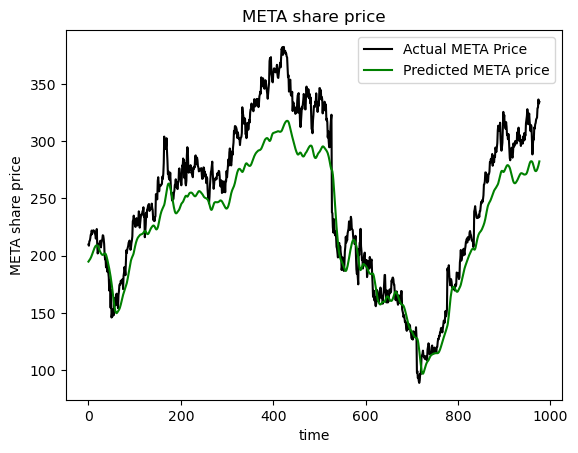

In [46]:
plt.plot(actual_price, color = 'black', label=f"Actual {company} Price")
plt.plot(predicted_prices, color = 'green', label=f"Predicted {company} price")
plt.title(f"{company} share price")
plt.xlabel('time')
plt.ylabel(f"{company} share price")
plt.legend()
plt.show()

##  Predict next day

In [47]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs)]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 1s 967ms/step
Prediction: [[284.02066]]
